<a href="https://colab.research.google.com/github/vigneshvalliappan/MSAI_CV_Project/blob/main/Playground/VGG_19L_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time

In [ ]:
# decide whether to compute using GPU

device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

In [ ]:
fold_0 = pd.read_csv('AdienceBenchmarkGenderAndAgeClassification/fold_0_data.txt',sep='\t')
fold_1 = pd.read_csv('AdienceBenchmarkGenderAndAgeClassification/fold_1_data.txt',sep='\t')
fold_2 = pd.read_csv('AdienceBenchmarkGenderAndAgeClassification/fold_2_data.txt',sep='\t')
fold_3 = pd.read_csv('AdienceBenchmarkGenderAndAgeClassification/fold_3_data.txt',sep='\t')
fold_4 = pd.read_csv('AdienceBenchmarkGenderAndAgeClassification/fold_4_data.txt',sep='\t')
fold_combined = pd.concat([fold_0,fold_1,fold_2,fold_3,fold_4],ignore_index=True)
print(f'Number of rows: {len(fold_combined)}')
fold_combined.info()

Number of rows: 19370
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [ ]:
fold_combined.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


['(25, 32)' '(38, 43)' '(4, 6)' '(60, 100)' '(15, 20)' '(48, 53)'
 '(8, 12)' '(0, 2)' 'None' '(38, 48)' '35' '3' '55' '58' '22' '13' '45'
 '36' '23' '(38, 42)' '(8, 23)' '(27, 32)' '57' '56' '2' '29' '34' '42'
 '46' '32']


<AxesSubplot:ylabel='age'>

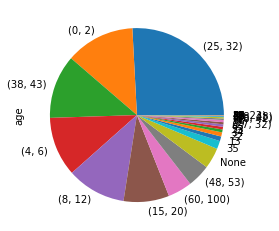

In [ ]:
# age break down
print(fold_combined.age.unique())
fold_combined.age.value_counts().plot.pie()

<AxesSubplot:xlabel='gender'>

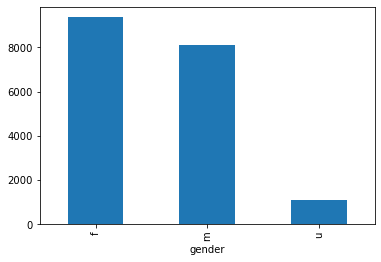

In [ ]:
# gender break down
fold_combined.groupby(['gender'])['gender'].count().plot.bar()

In [ ]:
# new column to record the file path
fold_combined['filepath'] = 'AdienceBenchmarkGenderAndAgeClassification/faces/' + fold_combined['user_id'] + '/coarse_tilt_aligned_face.' + fold_combined['face_id'].astype('str') + '.' + fold_combined['original_image']
fold_combined['filepath']

0        AdienceBenchmarkGenderAndAgeClassification/fac...
1        AdienceBenchmarkGenderAndAgeClassification/fac...
2        AdienceBenchmarkGenderAndAgeClassification/fac...
3        AdienceBenchmarkGenderAndAgeClassification/fac...
4        AdienceBenchmarkGenderAndAgeClassification/fac...
                               ...                        
19365    AdienceBenchmarkGenderAndAgeClassification/fac...
19366    AdienceBenchmarkGenderAndAgeClassification/fac...
19367    AdienceBenchmarkGenderAndAgeClassification/fac...
19368    AdienceBenchmarkGenderAndAgeClassification/fac...
19369    AdienceBenchmarkGenderAndAgeClassification/fac...
Name: filepath, Length: 19370, dtype: object

In [ ]:
# filtered of unlabelled data
print(len(fold_combined))
fold_combined = fold_combined[fold_combined['age'] != 'None']
fold_combined = fold_combined[fold_combined['gender'] != 'u']
fold_combined = fold_combined[fold_combined['gender'].notna()]
print(len(fold_combined))

19370
17452


In [ ]:
# formulating age class
with open('age_class.json') as f:
    age_class = json.load(f)

fold_combined['age'] = fold_combined['age'].apply(lambda x: age_class[x])
fold_combined.age.value_counts()

25-36    5493
38-47    2435
8-14     2286
4-6      2139
15-24    1885
0-3      1418
48-59     930
60+       866
Name: age, dtype: int64

In [ ]:
# convert class to int
def labelling_age(age_range):
    if age_range == '0-3':
        return 0
    elif age_range == '4-6':
        return 1
    elif age_range == '8-14':
        return 2
    elif age_range == '15-24':
        return 3
    elif age_range == '25-36':
        return 4
    elif age_range == '38-47':
        return 5
    elif age_range == '48-59':
        return 6
    elif age_range == '60+':
        return 7


fold_combined['label_age'] = fold_combined['age'].apply(labelling_age)
fold_combined.label_age.value_counts()

4    5493
5    2435
2    2286
1    2139
3    1885
0    1418
6     930
7     866
Name: label_age, dtype: int64

In [ ]:
# gender class
fold_combined.gender.value_counts()

f    9332
m    8120
Name: gender, dtype: int64

In [ ]:
# convert class to int
def labelling_gender(gender_range):
    if gender_range == 'm':
        result = 0
    elif gender_range == 'f':
        result = 1
    else:
        print(gender_range)
    return result

fold_combined['label_gender'] = fold_combined['gender'].apply(labelling_gender)
fold_combined.label_gender.value_counts()

1    9332
0    8120
Name: label_gender, dtype: int64

In [ ]:
fold_combined

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,filepath,label_age,label_gender
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,25-36,f,0,414,1086,1383,-115,30,17,AdienceBenchmarkGenderAndAgeClassification/fac...,4,1
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,25-36,m,301,105,640,641,0,0,94,AdienceBenchmarkGenderAndAgeClassification/fac...,4,0
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,25-36,f,2395,876,771,771,175,-30,74,AdienceBenchmarkGenderAndAgeClassification/fac...,4,1
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,25-36,m,752,1255,484,485,180,0,47,AdienceBenchmarkGenderAndAgeClassification/fac...,4,0
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,25-36,m,175,80,769,768,-75,0,34,AdienceBenchmarkGenderAndAgeClassification/fac...,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19341,101515718@N03,10587826073_6663f5b654_o.jpg,2280,25-36,f,718,748,492,492,0,0,63,AdienceBenchmarkGenderAndAgeClassification/fac...,4,1
19342,101515718@N03,10587571495_a61785cd06_o.jpg,2278,25-36,m,48,472,768,768,-15,0,25,AdienceBenchmarkGenderAndAgeClassification/fac...,4,0
19343,101515718@N03,10587571495_a61785cd06_o.jpg,2279,25-36,f,950,0,692,687,-5,0,27,AdienceBenchmarkGenderAndAgeClassification/fac...,4,1
19344,50458575@N08,9426695459_9e8b347604_o.jpg,2281,25-36,f,831,895,899,899,0,15,59,AdienceBenchmarkGenderAndAgeClassification/fac...,4,1


# Gender Model

In [ ]:
X = fold_combined['filepath']
y = fold_combined['label_gender']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=99)

print(f'train X shape: {len(X_train)}')
print(f'test x shape: {len(X_test)}')
print(f'train y shape: {len(y_train)}')
print(f'test y shape: {len(y_test)}')

train X shape: 13089
test x shape: 4363
train y shape: 13089
test y shape: 4363


In [ ]:
y_train = torch.from_numpy(np.asarray(y_train))
y_train = y_train.type(torch.long)
y_test = torch.from_numpy(np.asarray(y_test))
y_test = y_test.type(torch.long)

print(f'y_train: {y_train.size()}')
print(f'y_test: {y_test.size()}')

y_train: torch.Size([13089])
y_test: torch.Size([4363])


In [ ]:
from PIL import Image

def get_image(series):
    results = []
    for row in series:
        image = Image.open(row)
        image = image.resize((256,256))
        results.append(np.asarray(image))
    return results

# convert list to array to tensor
X_train_images = torch.from_numpy(np.asarray(get_image(X_train)))
X_train_images = X_train_images.permute(0, 3, 1, 2)
X_train_images = X_train_images.type(torch.float)
print(f'X_train_images: {X_train_images.size()}')

X_test_images = torch.from_numpy(np.asarray(get_image(X_test)))
X_test_images = X_test_images.permute(0, 3, 1, 2)
X_test_images = X_test_images.type(torch.float)
print(f'X_test_images: {X_test_images.size()}')


X_train_images: torch.Size([13089, 3, 256, 256])
X_test_images: torch.Size([4363, 3, 256, 256])


In [ ]:
class model_gender(nn.Module): # VGG_convnet 19 layers

    def __init__(self):
        super(model_gender,self).__init__()

        # block 1:         3 x 256 x 256 --> 64 x 64 x 64        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.conv1c = nn.Conv2d(64,  64,  kernel_size=3, padding=1 ) # added this layer
        self.pool1  = nn.MaxPool2d(4,4)

        # block 2:         64 x 64 x 64 --> 128 x 16 x 16
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.conv2c = nn.Conv2d(128, 128, kernel_size=3, padding=1 ) # added this layer
        self.pool2  = nn.MaxPool2d(4,4)

        # block 3:         128 x 16 x 16 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.conv3c = nn.Conv2d(256, 256, kernel_size=3, padding=1 ) # added this layer
        self.conv3d = nn.Conv2d(256, 256, kernel_size=3, padding=1 ) # added this layer
        self.conv3e = nn.Conv2d(256, 256, kernel_size=3, padding=1 ) # added this layer
        self.pool3  = nn.MaxPool2d(4,4)
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.conv4b = nn.Conv2d(512, 512, kernel_size=3, padding=1 ) # added this layer
        self.conv4c = nn.Conv2d(512, 512, kernel_size=3, padding=1 ) # added this layer
        self.conv4d = nn.Conv2d(512, 512, kernel_size=3, padding=1 ) # added this layer
        self.conv4e = nn.Conv2d(512, 512, kernel_size=3, padding=1 ) # added this layer
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)
        
    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.conv1c(x) # added this
        x = torch.relu(x) # added this
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.conv2c(x) # added this
        x = torch.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.conv3c(x)
        x = torch.relu(x)
        x = self.conv3d(x)
        x = torch.relu(x)
        x = self.conv3e(x)
        x = torch.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = torch.relu(x)
        x = self.conv4b(x)
        x = torch.relu(x)
        x = self.conv4c(x)
        x = torch.relu(x)
        x = self.conv4d(x)
        x = torch.relu(x)
        x = self.conv4e(x)
        x = torch.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x) 
        
        return x

In [ ]:
net_gender = model_gender()
print(net_gender)

model_gender(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(

In [ ]:
# send net_gender to device
net_gender = net_gender.to(device)

In [ ]:
mean = X_train_images.mean()
print(mean)
std = X_train_images.std()
print(std)
criterion = nn.CrossEntropyLoss()
my_lr=0.25 
bs= 128

tensor(90.5548)
tensor(67.4386)


In [ ]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs    

In [ ]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,4363,bs):

        minibatch_data =  X_test_images[i:i+bs]
        minibatch_label= y_test[i:i+bs]

        #send to GPU, if desired
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std

        scores=net_gender( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1

    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

In [ ]:
start=time.time()

for epoch in range(1,20):
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    if epoch==10 or epoch == 14 or epoch==18:
        my_lr = my_lr / 2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net_gender.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    # set the order in which to visit the image from the training set
    shuffled_indices=torch.randperm(13089)
 
    for count in range(0,13089,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  X_train_images[indices]
        minibatch_label=  y_train[indices]

        # send them to the gpu, if desired
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # normalize the minibatch (this is the only difference compared to before!)
        inputs = (minibatch_data - mean)/std
        
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net_gender( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        
        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
        print(f'{num_batches} : {(time.time()-start)/60}')
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60

    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')

1 : 1.9936955173810322
2 : 3.9313342849413555
3 : 5.9126296202341715
4 : 7.900851436456045
5 : 9.909158984820047
6 : 11.908407135804493
7 : 13.854943617184956
8 : 15.79875871737798
9 : 17.752450784047443
10 : 19.686124670505524
11 : 21.60721675157547
12 : 23.54082055489222
13 : 25.471939488252005
14 : 27.42719433307648
15 : 29.355574599901836
16 : 31.30043601989746
17 : 33.250105901559195
18 : 35.19205425182978
19 : 37.138237953186035
20 : 39.081157982349396
21 : 41.02367736895879
22 : 42.95955241918564
23 : 44.8932475010554
24 : 46.86337323586146
25 : 48.80582593282064
26 : 50.7379532178243
27 : 52.611191999912265
28 : 54.559447554747265
29 : 56.489880271752675
30 : 58.42907652060191
31 : 60.34893973271052
32 : 62.27012633879979
33 : 64.14654221932093
34 : 66.0494814157486
35 : 67.95650086800258
36 : 69.8889658689499
37 : 71.81984064976375
38 : 73.75865131616592
39 : 75.67192706664403
40 : 77.5968244989713
41 : 79.51199173529943
42 : 81.40196735064188
43 : 83.27592279911042
44 : 85.17